# Required Imports #

In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.linear_model
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

data = pd.read_csv("project2.data")

# Data Preprocessing and Visualization (Part 1) #

## Preprocessing ##

Shape and Size of the data set!!

In [437]:
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


(286, 10)

In [438]:
data.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [439]:
## Despite there being a lot of object data-types I don't think conversion is necessary!!
## Besides One-Hot encoding, there seems to be some potential maybe later!!

In [440]:
print(data.isnull().values.any())

False


In [441]:
## There are no null cells!!

In [442]:
print("Number of unique values for each header starting from class to irradiat!!")
print(len(data['class'].unique()), len(data['age'].unique()), len(data['menopause'].unique()),
      len(data['tumor-size'].unique()), len(data['inv-nodes'].unique()), 
      len(data['node-caps'].unique()), len(data['deg-malig'].unique()),
      len(data['breast'].unique()), len(data['breast-quad'].unique()),
      len(data['irradiat'].unique()))

Number of unique values for each header starting from class to irradiat!!
2 6 3 11 7 3 3 2 6 2


Almost every value is a string or a range of numbers making the object data type valid.
Although there's 6 categories that I think would be easier with one hot encoding!!
aka the catagories with <= 3 unique values!!

In [443]:
print("class:" , data['class'].unique())
print("age:" , data['age'].unique())
print("tumor-size:" , data['tumor-size'].unique())
print("menopause:" , data['menopause'].unique())
print("inv-nodes:" , data['inv-nodes'].unique())
print("node-caps:" , data['node-caps'].unique())
print("deg-malig:" , data['deg-malig'].unique())
print("breast:" , data['breast'].unique())
print("breast-quad:" , data['breast-quad'].unique())
print("irradiat:" , data['irradiat'].unique())

class: ['no-recurrence-events' 'recurrence-events']
age: ['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
tumor-size: ['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
menopause: ['premeno' 'ge40' 'lt40']
inv-nodes: ['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']
node-caps: ['no' 'yes' '?']
deg-malig: [3 2 1]
breast: ['left' 'right']
breast-quad: ['left_low' 'right_up' 'left_up' 'right_low' 'central' '?']
irradiat: ['no' 'yes']


Of the categories 2 have an odd unique value, above we see that the node-caps and deg-malig categories have a unique value of '?' which isnt a valid value. Not to mention the fact that there are numbers in some columns but in ranges.

Let's handle the node-caps invalid values. After analyzing the dataset a bit more I tried to look for a correlation between the node-caps column and the rest. At first, it seemed to be random but I noticed a slight trend with the irradiat column being almost always the same as the node-caps.

In [444]:
invalidNC = 0
for i, row in data[data['node-caps'] == '?'].iterrows():
    invalidNC += 1
print("Invalid Values: ", invalidNC)

Invalid Values:  8


In [445]:
countNN = 0
countYY = 0
for i, row in data[data['irradiat'] == 'no'].iterrows():
    if row['node-caps'] == 'no':
        countNN = countNN + 1
for i, row in data[data['irradiat'] == 'yes'].iterrows():
    if row['node-caps'] == 'yes':
        countYY = countYY + 1
print("Correlation Probability b/w Irradiat & node-caps: ", (countNN + countYY)/(286-invalidNC))
print("Probability of Invalid values: ", invalidNC/286)

Correlation Probability b/w Irradiat & node-caps:  0.7769784172661871
Probability of Invalid values:  0.027972027972027972


Not bad in all honesty!! Ill use it as a basis seeing as the probability of invalid values is super low!!

In [446]:
for i, row in data[data['node-caps'] == '?'].iterrows():
    data.at[i, 'node-caps'] = data.at[i, 'irradiat']
print("node-caps:" , data['node-caps'].unique())

node-caps: ['no' 'yes']


Now we can handle the breast-quad column!!

In [447]:
invalid = 0
rowNum = 0
for i, row in data[data['breast-quad'] == '?'].iterrows():
    invalid += 1
    rowNum = i
print('Number of Invalid values: ', invalid)

Number of Invalid values:  1


Seeing as there is only one invalid value, I analyzed the dataset again to look for similarities between the different categories and there is not really a simple way to choose the value so im going to drop it seeing as it is the only one.

In [448]:
data.drop(data[data['breast-quad'] == "?"].index,inplace=True)
print("breast-quad:" , data['breast-quad'].unique())

breast-quad: ['left_low' 'right_up' 'left_up' 'right_low' 'central']


## Uni/Multivariate Analysis ##

/usr/local/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

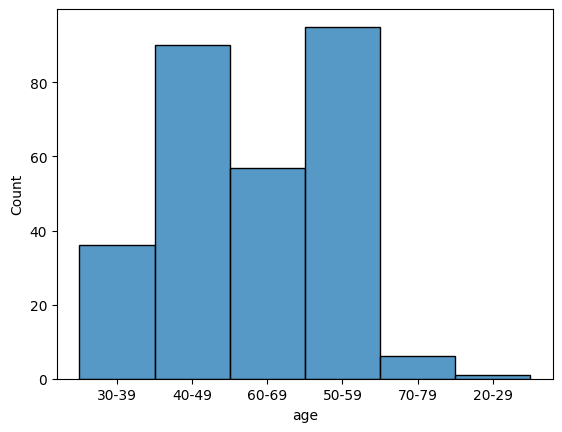

In [449]:
sns.histplot(data=data['age'])

Most cases are in the 40-60 age range.

<Axes: xlabel='breast-quad', ylabel='count'>

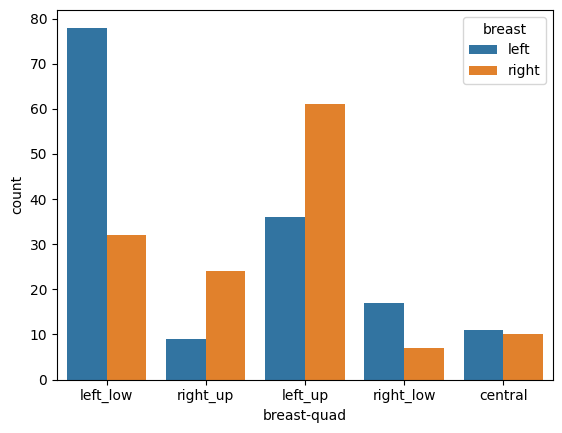

In [450]:
sns.countplot(x=data['breast-quad'], hue=data['breast'])

Of the cases majority are in the left breast dominating in the left lower/upper quadrant, which is interesting.

<Axes: xlabel='deg-malig'>

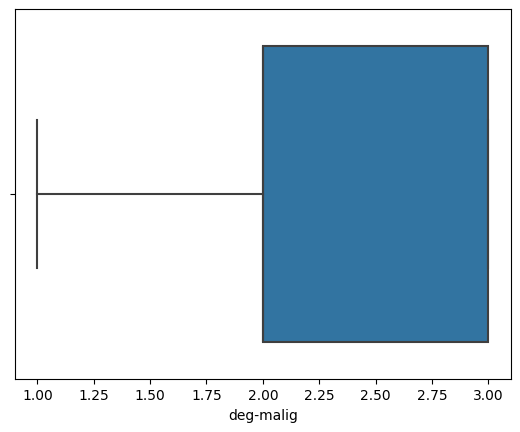

In [451]:
sns.boxplot(data=data, x='deg-malig')

I can't perform any other box plots without more int values so let's do some one-hot encoding and maybe even something about those ranges!!

In [452]:
data['class'] = data['class'].astype("category")
data['menopause'] = data['menopause'].astype("category")
data['node-caps'] = data['node-caps'].astype("category")
data['breast'] = data['breast'].astype("category")
data['breast-quad'] = data['breast-quad'].astype("category")
data['irradiat'] = data['irradiat'].astype("category")

data = pd.get_dummies(data, columns=["class","menopause","node-caps","breast","breast-quad","irradiat"], drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 0 to 285
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   age                      285 non-null    object
 1   tumor-size               285 non-null    object
 2   inv-nodes                285 non-null    object
 3   deg-malig                285 non-null    int64 
 4   class_recurrence-events  285 non-null    bool  
 5   menopause_lt40           285 non-null    bool  
 6   menopause_premeno        285 non-null    bool  
 7   node-caps_yes            285 non-null    bool  
 8   breast_right             285 non-null    bool  
 9   breast-quad_left_low     285 non-null    bool  
 10  breast-quad_left_up      285 non-null    bool  
 11  breast-quad_right_low    285 non-null    bool  
 12  breast-quad_right_up     285 non-null    bool  
 13  irradiat_yes             285 non-null    bool  
dtypes: bool(10), int64(1), object(3)
memory usage: 

In [453]:
print(data['age'].unique())
print(data['tumor-size'].unique())
print(data['inv-nodes'].unique())

['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']


In [454]:
def rangechange(rangeVal):
    start, end = map(int, rangeVal.split('-'))
    return (start + end) // 2

data['age'] = data['age'].apply(rangechange).astype(int)
data['tumor-size'] = data['tumor-size'].apply(rangechange).astype(int)
data['inv-nodes'] = data['inv-nodes'].apply(rangechange).astype(int)

In [455]:
print(data['age'].unique())
print(data['tumor-size'].unique())
print(data['inv-nodes'].unique())
data.describe()

[34 44 64 54 74 24]
[32 22 17  2 27 52 12 42 37  7 47]
[ 1  7 10  4 16 13 25]


,age,tumor-size,inv-nodes,deg-malig
count,285.000000,285.000000,285.000000,285.000000
mean,50.631579,26.385965,2.578947,2.045614
std,10.134017,10.542928,3.456711,0.737351
min,24.000000,2.000000,1.000000,1.000000
25%,44.000000,22.000000,1.000000,2.000000
50%,54.000000,27.000000,1.000000,2.000000
75%,54.000000,32.000000,4.000000,3.000000
max,74.000000,52.000000,25.000000,3.000000


Now that I generalized these values we can apply some more univariate analysis!!

<Axes: xlabel='tumor-size'>

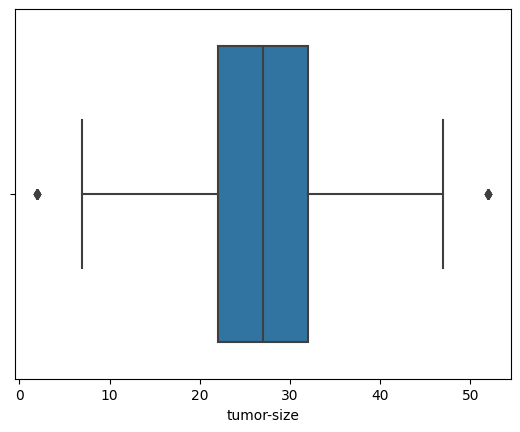

In [456]:
sns.boxplot(data=data, x='tumor-size')

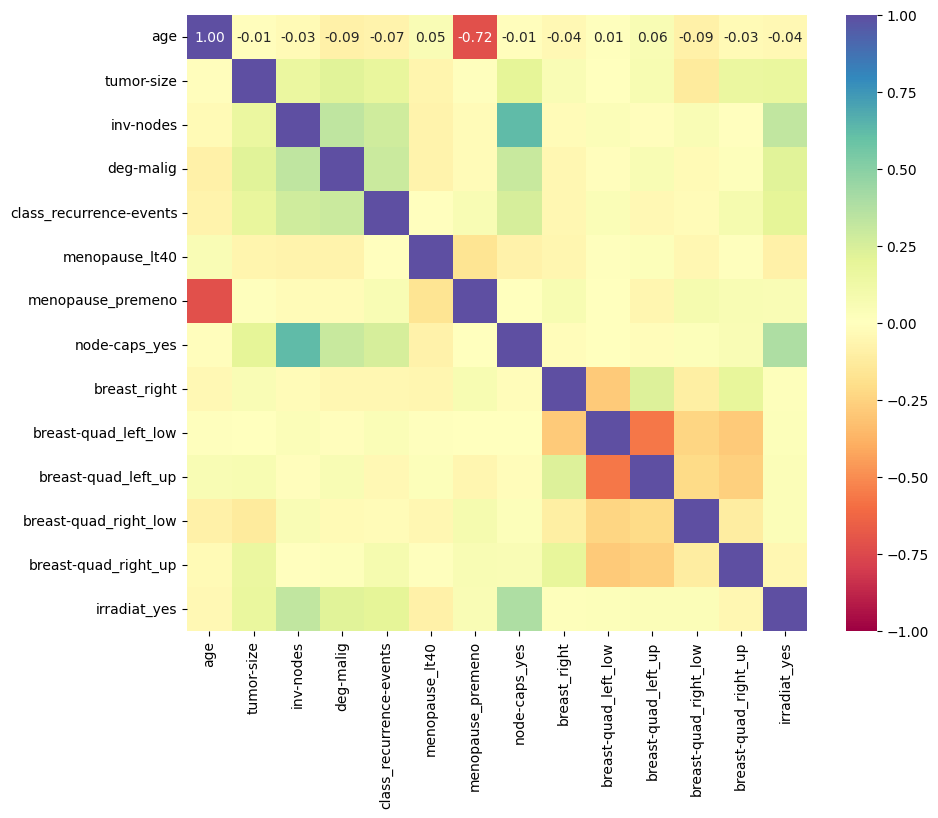

In [457]:
data_cols = data.columns
plt.figure(figsize=(10, 8))

sns.heatmap(data[data_cols].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")

plt.show()

# Building and Assessing Models (Part 2) #

In [458]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 0 to 285
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   age                      285 non-null    int64
 1   tumor-size               285 non-null    int64
 2   inv-nodes                285 non-null    int64
 3   deg-malig                285 non-null    int64
 4   class_recurrence-events  285 non-null    bool 
 5   menopause_lt40           285 non-null    bool 
 6   menopause_premeno        285 non-null    bool 
 7   node-caps_yes            285 non-null    bool 
 8   breast_right             285 non-null    bool 
 9   breast-quad_left_low     285 non-null    bool 
 10  breast-quad_left_up      285 non-null    bool 
 11  breast-quad_right_low    285 non-null    bool 
 12  breast-quad_right_up     285 non-null    bool 
 13  irradiat_yes             285 non-null    bool 
dtypes: bool(10), int64(4)
memory usage: 13.9 KB


In [459]:
X = data.drop("class_recurrence-events", axis=1)
Y = data["class_recurrence-events"]

In [460]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=1)
print(X_train.shape,X_test.shape)

(199, 13) (86, 13)


## KNeighbor ##

In [461]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [462]:
knn = KNeighborsClassifier(n_neighbors=6)

knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=6)

In [463]:
accuracy_test=accuracy_score(Y_test, knn.predict(X_test))
print('Accuracy of knn on test data is : {:.2}'.format(accuracy_test))

# Check accuracy on the training data
accuracy_train=accuracy_score(Y_train, knn.predict(X_train))
print('Accuracy of knn on train data is : {:.2}'.format(accuracy_train))

Accuracy of knn on test data is : 0.69
Accuracy of knn on train data is : 0.73


In [464]:
knnAccuracy = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 100)}
knn_gscv = GridSearchCV(knnAccuracy, param_grid, cv=5, scoring="recall")
knn_gscv.fit(X_train, Y_train)
knn_gscv.best_params_

{'n_neighbors': 1}

In [465]:
print("                    KN TEST PERFORMANCE")
print(classification_report(Y_test, knn_gscv.best_estimator_.predict(X_test)))
print("                   KN TRAIN PERFORMANCE")
print(classification_report(Y_train, knn_gscv.best_estimator_.predict(X_train)))

                    KN TEST PERFORMANCE
              precision    recall  f1-score   support

       False       0.70      0.70      0.70        61
        True       0.28      0.28      0.28        25

    accuracy                           0.58        86
   macro avg       0.49      0.49      0.49        86
weighted avg       0.58      0.58      0.58        86

                   KN TRAIN PERFORMANCE
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       140
        True       0.95      0.97      0.96        59

    accuracy                           0.97       199
   macro avg       0.97      0.97      0.97       199
weighted avg       0.98      0.97      0.97       199



## Random Forest ##

In [466]:
model = RandomForestClassifier()
param_grid = {
   "n_estimators": np.arange(start=10, stop=100, step=2),
   "max_depth": np.arange(start=2, stop=20),
   "min_samples_leaf": np.arange(start=1, stop=5),
   "class_weight": [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}],
}

fr_gscv = GridSearchCV(model, param_grid, cv=5, n_jobs=8, scoring="recall", )
fr_gscv.fit(X_train, Y_train)
fr_gscv.best_params_

{'class_weight': {0: 0.1, 1: 0.9},
 'max_depth': 2,
 'min_samples_leaf': 1,
 'n_estimators': 16}

In [467]:
print("                    RF TEST PERFORMANCE")
print(classification_report(Y_test, fr_gscv.best_estimator_.predict(X_test)))
print("                   RF TRAIN PERFORMANCE")
print(classification_report(Y_train, fr_gscv.best_estimator_.predict(X_train)))

                    RF TEST PERFORMANCE
              precision    recall  f1-score   support

       False       1.00      0.03      0.06        61
        True       0.30      1.00      0.46        25

    accuracy                           0.31        86
   macro avg       0.65      0.52      0.26        86
weighted avg       0.80      0.31      0.18        86

                   RF TRAIN PERFORMANCE
              precision    recall  f1-score   support

       False       1.00      0.05      0.10       140
        True       0.31      1.00      0.47        59

    accuracy                           0.33       199
   macro avg       0.65      0.53      0.28       199
weighted avg       0.79      0.33      0.21       199



## Decision Tree ##

In [468]:
dt_gscv = DecisionTreeClassifier(random_state=1).fit(X_train, Y_train)

In [469]:
print("                    RF TEST PERFORMANCE")
print(classification_report(Y_test, dt_gscv.predict(X_test)))
print("                   RF TRAIN PERFORMANCE")
print(classification_report(Y_train, dt_gscv.predict(X_train)))

                    RF TEST PERFORMANCE
              precision    recall  f1-score   support

       False       0.76      0.72      0.74        61
        True       0.39      0.44      0.42        25

    accuracy                           0.64        86
   macro avg       0.58      0.58      0.58        86
weighted avg       0.65      0.64      0.65        86

                   RF TRAIN PERFORMANCE
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       140
        True       1.00      0.92      0.96        59

    accuracy                           0.97       199
   macro avg       0.98      0.96      0.97       199
weighted avg       0.98      0.97      0.97       199

